In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# Specify your location

import os 
root = '/content/drive/MyDrive/Colab_Notebooks'
os.chdir(root)
print(os.getcwd())

/content/drive/MyDrive/Colab_Notebooks


In [ ]:
# Video configs

NETWORK = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
STEPS = 150
FPS = 30
FREEZE_STEPS = 30

In [19]:
# Upload Source Image

import os
from google.colab import files

uploaded = files.upload()

if len(uploaded) != 1:
  print("Upload exactly 1 file for source.")
else:
  for k, v in uploaded.items():
    _, ext = os.path.splitext(k)
    os.remove(k)
    SOURCE_NAME = f"source{ext}"
    open(SOURCE_NAME, 'wb').write(v)

Saving ben2.jpg to ben2.jpg


Also, choose your ending image.

In [20]:
# Upload Target Image

uploaded = files.upload()

if len(uploaded) != 1:
  print("Upload exactly 1 file for target.")
else:
  for k, v in uploaded.items():
    _, ext = os.path.splitext(k)
    os.remove(k)
    TARGET_NAME = f"target{ext}"
    open(TARGET_NAME, 'wb').write(v)

Saving target.jpg to target.jpg


In [21]:
# To get the Face landmarks

!wget http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_5_face_landmarks.dat.bz2

--2021-06-20 12:31:35--  http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5706710 (5.4M)
Saving to: ‘shape_predictor_5_face_landmarks.dat.bz2’

shape_predictor_5_f 100%[===================>]   5.44M  6.79MB/s    in 0.8s    

2021-06-20 12:31:36 (6.79 MB/s) - ‘shape_predictor_5_face_landmarks.dat.bz2’ saved [5706710/5706710]



In [22]:
# Clone the official Repository

import sys
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
!pip install ninja
sys.path.insert(0, "/content/drive/MyDrive/Colab_Notebooks/stylegan2-ada-pytorch")

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 125, done.
remote: Total 125 (delta 0), reused 0 (delta 0), pack-reused 125
Receiving objects: 100% (125/125), 1.12 MiB | 16.90 MiB/s, done.
Resolving deltas: 100% (55/55), done.


# Preprocess Images for Best StyleGAN Results

The following are helper functions for the preprocessing.

In [23]:
import cv2
import numpy as np
from PIL import Image
import dlib

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_5_face_landmarks.dat')

def find_eyes(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  rects = detector(gray, 0)
  
  if len(rects) == 0:
    raise ValueError("No faces detected")
  elif len(rects) > 1:
    raise ValueError("Multiple faces detected")

  shape = predictor(gray, rects[0])
  features = []

  for i in range(0, 5):
    features.append((i, (shape.part(i).x, shape.part(i).y)))

  return (int(features[3][1][0] + features[2][1][0]) // 2, \
    int(features[3][1][1] + features[2][1][1]) // 2), \
    (int(features[1][1][0] + features[0][1][0]) // 2, \
    int(features[1][1][1] + features[0][1][1]) // 2)

def crop_stylegan(img):
  left_eye, right_eye = find_eyes(img)
  d = abs(right_eye[0] - left_eye[0])
  z = 255/d
  ar = img.shape[0]/img.shape[1]
  w = img.shape[1] * z
  img2 = cv2.resize(img, (int(w), int(w*ar)))
  bordersize = 1024
  img3 = cv2.copyMakeBorder(
      img2,
      top=bordersize,
      bottom=bordersize,
      left=bordersize,
      right=bordersize,
      borderType=cv2.BORDER_REPLICATE)

  left_eye2, right_eye2 = find_eyes(img3)

  crop1 = left_eye2[0] - 385 
  crop0 = left_eye2[1] - 490
  return img3[crop0:crop0+1024,crop1:crop1+1024]

The following will preprocess and crop your images.  If you receive an error indicating multiple faces were found, try to crop your image better or obscure the background.  If the program does not see a face, then attempt to obtain a clearer and more high-resolution image.

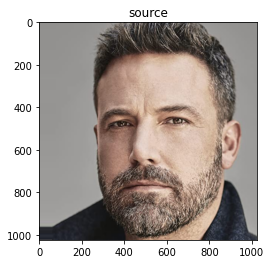

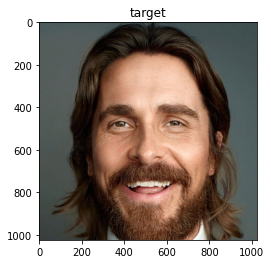

True

In [24]:
from matplotlib import pyplot as plt
import cv2

image_source = cv2.imread(SOURCE_NAME)
if image_source is None:
    raise ValueError("Source image not found")

image_target = cv2.imread(TARGET_NAME)
if image_target is None:
    raise ValueError("Source image not found")

cropped_source = crop_stylegan(image_source)
cropped_target = crop_stylegan(image_target)

img = cv2.cvtColor(cropped_source, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('source')
plt.show()

img = cv2.cvtColor(cropped_target, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('target')
plt.show()

cv2.imwrite("cropped_source.png", cropped_source)
cv2.imwrite("cropped_target.png", cropped_target)

#print(find_eyes(cropped_source))
#print(find_eyes(cropped_target))

# Convert Source to a GAN

First, we convert the source to a GAN latent vector.  This process will take several minutes.

In [25]:
cmd = f"python /content/drive/MyDrive/Colab_Notebooks/stylegan2-ada-pytorch/projector.py --save-video 0 --num-steps 3000 --outdir=out_source --target=cropped_source.png --network={NETWORK}"
!{cmd}

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
Computing W midpoint and stddev using 10000 samples...
Setting up PyTorch plugin "bias_act_plugin"... Done.
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
step    1/3000: dist 0.67 loss 24567.33
step    2/3000: dist 0.72 loss 27640.70
step    3/3000: dist 0.70 loss 27481.04
step    4/3000: dist 0.55 loss 27164.56
step    5/3000: dist 0.61 loss 26700.01
step    6/3000: dist 0.69 loss 26097.52
step    7/3000: dist 0.56 loss 25368.93
step    8/3000: dist 0.60 loss 24529.23
step    9/3000: dist 0.60 loss 23593.43
step   10/3

# Convert Target to a GAN

Next, we convert the target to a GAN latent vector.  This process will also take several minutes.

In [26]:
cmd = f"python /content/drive/MyDrive/Colab_Notebooks/stylegan2-ada-pytorch/projector.py --save-video 0 --num-steps 3000 --outdir=out_target --target=cropped_target.png --network={NETWORK}"
!{cmd}

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
Computing W midpoint and stddev using 10000 samples...
Setting up PyTorch plugin "bias_act_plugin"... Done.
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
step    1/3000: dist 0.60 loss 24567.27
step    2/3000: dist 0.59 loss 27640.57
step    3/3000: dist 0.62 loss 27480.96
step    4/3000: dist 0.55 loss 27164.56
step    5/3000: dist 0.54 loss 26699.94
step    6/3000: dist 0.63 loss 26097.46
step    7/3000: dist 0.55 loss 25368.92
step    8/3000: dist 0.58 loss 24529.20
step    9/3000: dist 0.55 loss 23593.39
step   10/3

With the conversion complete, lets have a look at the two GANs.

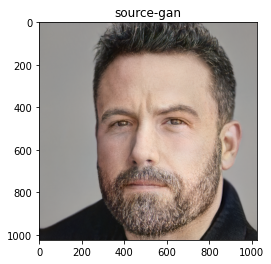

In [27]:
img_gan_source = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/out_source/proj.png')
img = cv2.cvtColor(img_gan_source, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('source-gan')
plt.show()

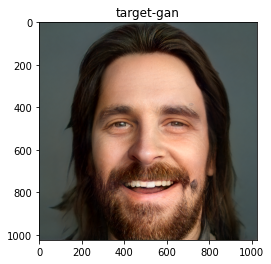

In [28]:
img_gan_target = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/out_target/proj.png')
img = cv2.cvtColor(img_gan_target, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('target-gan')
plt.show()

# Build the Video

The following code builds a transition video between the two latent vectors previously obtained.

In [29]:
import torch
import dnnlib
import legacy
import PIL.Image
import numpy as np
import imageio
from tqdm.notebook import tqdm

# Location of the projected image

lvec1 = np.load('/content/drive/MyDrive/Colab_Notebooks/out_source/projected_w.npz')['w']
lvec2 = np.load('/content/drive/MyDrive/Colab_Notebooks/out_target/projected_w.npz')['w']

network_pkl = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as fp:
    G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device) # type: ignore

diff = lvec2 - lvec1
step = diff / STEPS
current = lvec1.copy()
target_uint8 = np.array([1024,1024,3], dtype=np.uint8)

video = imageio.get_writer('/content/drive/MyDrive/Colab_Notebooks/movie.mp4', mode='I', fps=FPS, codec='libx264', bitrate='16M') # Specify where u want to save 

for j in tqdm(range(STEPS)):
  z = torch.from_numpy(current).to(device)
  synth_image = G.synthesis(z, noise_mode='const')
  synth_image = (synth_image + 1) * (255/2)
  synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()

  repeat = FREEZE_STEPS if j==0 or j==(STEPS-1) else 1
   
  for i in range(repeat):
    video.append_data(synth_image)
  current = current + step


video.close()

# Download your Video

If you made it through all of these steps, you are now ready to download your video.

In [30]:
# To download the Video 

from google.colab import files
files.download("movie.mp4") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>